# References:

@book{bhooshan_2012,
place={New Delhi, India},
edition={1},
title={Fundamentals of engineering electromagnetics},
publisher={Oxford University Press},
author={Bhooshan, Sunil},
year={2012},
pages={269-272}
}

In [1]:
from sympy import *
init_printing()

import numpy as np

import xarray as xr
import itertools as Iter

import scipy.constants as consts

# The Static Field Prelude

## Theory 

In [2]:
x, y, z=symbols('x, y, z')
xDirVec=Matrix([1, 0, 0]); yDirVec=Matrix([0, 1, 0]); zDirVec=Matrix([0, 0, 1])

In [3]:
DieElecConst=symbols('epsilon_0')
sups_physical={DieElecConst:consts.epsilon_0}; sups_physical

In [4]:
EPot=Function('V')(x, y, z); EPot

In [5]:
ChargeDen_line=symbols('rho_ell'); ChargeDen_line
sups={ChargeDen_line:1}; sups

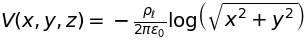

In [6]:
EPotLine=Eq(EPot, -ChargeDen_line/(2*pi*DieElecConst) *ln(sqrt(y**2+x**2)))
EPotLine

In [7]:
MPot=Function('A')(x, y, z); MPot

In [8]:
MagConst=symbols('mu_0')
sups_physical[MagConst]=consts.mu_0; sups_physical

In [9]:
Current=symbols('I')
sups[Current]=1; sups

In [10]:
#MPotLine=Eq(MPot, -(Current*zDirVec)/(2*pi*MagConst) *ln(sqrt(y**2+x**2)))
#@Sympy this above is what I want to do; below is what I had to do
#yeah the Matrix Equation stuff needs some major improvments

MPotLine= -(Current*zDirVec)/(2*pi*MagConst) *ln(sqrt(y**2+x**2))
MPotLine

⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢      ⎛   _________⎞ ⎥
⎢      ⎜  ╱  2    2 ⎟ ⎥
⎢-I⋅log⎝╲╱  x  + y  ⎠ ⎥
⎢─────────────────────⎥
⎣        2⋅π⋅μ₀       ⎦

## Numericalizing sympy 

In [11]:
MPotLineN=lambdify((x, y, z), MPotLine.subs({**sups_physical, **sups}), dummify=False)
MPotLineN(1,1,1)

array([[     0.        ],
       [     0.        ],
       [-43894.05798293]])

In [12]:
EPotLineN=lambdify((x, y, z), EPotLine.rhs.subs({**sups_physical, **sups}), dummify=False)
EPotLineN(1,1,1)

## DataCube Loading

Huge Thanks to [@shoyer](https://github.com/shoyer) & [@fmaussion](https://github.com/fmaussion) for helping me get the Numerical Sympy loaded into `xarray` (see [xarray issue] (https://github.com/pydata/xarray/issues/1773#issuecomment-350974418) )

In [13]:
DomainSpaceSize=5
SpaceDensity=500

In [14]:
x_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity)
y_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity)
z_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity)

In [15]:
SpaceOnlyCoorEnterFunc = lambda x, y, z: 1+ (0*x+0*y+0*z)

In [16]:
StaticSimDataSet = xr.Dataset(
    {'CoorSpace':(['x', 'y', 'z'], SpaceOnlyCoorEnterFunc(*np.meshgrid(x_coord, y_coord, z_coord)))},
                  coords={'x':x_coord, 'y':y_coord, 'z':z_coord})
StaticSimDataSet

<xarray.Dataset>
Dimensions:    (x: 500, y: 500, z: 500)
Coordinates:
  * x          (x) float64 -5.0 -4.98 -4.96 -4.94 -4.92 -4.9 -4.88 -4.86 ...
  * y          (y) float64 -5.0 -4.98 -4.96 -4.94 -4.92 -4.9 -4.88 -4.86 ...
  * z          (z) float64 -5.0 -4.98 -4.96 -4.94 -4.92 -4.9 -4.88 -4.86 ...
Data variables:
    CoorSpace  (x, y, z) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...

In [17]:
StaticMasterShape=StaticSimDataSet['CoorSpace'].shape; StaticMasterShape

In [18]:
StaticSimDataSet['EPot']=(['x', 'y', 'z'], EPotLineN(*np.meshgrid(x_coord, y_coord, z_coord)))
StaticSimDataSet.info()

xarray.Dataset {
dimensions:
	x = 500 ;
	y = 500 ;
	z = 500 ;

variables:
	float64 CoorSpace(x, y, z) ;
	float64 x(x) ;
	float64 y(y) ;
	float64 z(z) ;
	float64 EPot(x, y, z) ;

// global attributes:
}

Worked on getting the vector into xarray since lambdfy's output is not broadcasting well at all; However ever the below soltion does not scale will need to redo